In [2]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Gin Rummy

## Imports

In [3]:
#-------------------------------------------------------------------------------
# The following code was originally written by Todd Neller in Java.
# It was translated into Python by Anthony Hein.
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# A class for modeling a game of Gin Rummy
# @author Todd W. Neller
# @version 1.0
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Copyright (C) 2020 Todd Neller
#
# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 2
# of the License, or (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# Information about the GNU General Public License is available online at:
#   http://www.gnu.org/licenses/
# To receive a copy of the GNU General Public License, write to the Free
# Software Foundation, Inc., 59 Temple Place - Suite 330, Boston, MA
# 02111-1307, USA.
#-------------------------------------------------------------------------------

%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
import random
import time
from Deck import Deck
from GinRummyUtil import GinRummyUtil
from SimpleGinRummyPlayer import SimpleGinRummyPlayer
from OpponentHandEstimationPlayer import OpponentHandEstimationPlayer

%cd /content/drive/My Drive/Colab Notebooks/Thesis
#-------------------------------------------------------------------------------
# TRACKING
import numpy as np
# tracking_states = []
# tracking_states2 = []
# tracking_hands = []
# tracking_handsO = []
# curr_hand = []
# knock = []
# winloss = []

# 11/25 - Track states after pickup, before discard
track_apbd_state = []
# track_apbd_card = []
track_apbd_action = []

# 12/01 - Track states before pickup, before discard
track_bpbd_state = []
track_bpbd_action = []

def one_hot(cards):
    ret = np.zeros(52)
    for card in cards:
        ret[card.getId()] = 1
    return ret

def un_one_hot(arr):
    rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
    # Changed the suits to match rlcard
    suitNames = ['S', 'H', 'D', 'C']#["C", "H", "S", "D"]
    ret = []
    for i in range(len(arr)):
        if arr[i] != 0:
            ret.append(rankNames[i%13] + suitNames[i//13])
    return ret
#-------------------------------------------------------------------------------

/content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
/content/drive/My Drive/Colab Notebooks/Thesis


## Class Definition/Data Part

In [ ]:
class GinRummyGame:

    # Hand size (before and after turn). After draw and before discard there is one extra card.
    HAND_SIZE = 10;

    # Whether or not to print information during game play
    playVerbose = False;

    # Two Gin Rummy players numbered according to their array index.
    players = [];

    # Set whether or not there is to be printed output during gameplay.
    def setPlayVerbose(playVerbose):
        GinRummyGame.playVerbose = playVerbose

    # Create a GinRummyGame with two given players
    def __init__(self, player0, player1):
        GinRummyGame.players.extend([player0, player1])

    # Play a game of Gin Rummy and return the winning player number 0 or 1.
    # @return the winning player number 0 or 1
    def play(self):
        scores = [0, 0]
        hands = []
        hands.extend([[], []])

        startingPlayer = random.randrange(2);

        # while game not over
        while scores[0] < GinRummyUtil.GOAL_SCORE and scores[1] < GinRummyUtil.GOAL_SCORE:

            currentPlayer = startingPlayer
            opponent = (1 if currentPlayer == 0 else 0)

            # get shuffled deck and deal cards
            deck = Deck.getShuffle(random.randrange(10 ** 8))
            hands[0] = []
            hands[1] = []
            for i in range(2 * GinRummyGame.HAND_SIZE):
                hands[i % 2] += [deck.pop()]
            for i in range(2):
                GinRummyGame.players[i].startGame(i, startingPlayer, hands[i]);
                if GinRummyGame.playVerbose:
                    print("Player %d is dealt %s.\n" % (i, hands[i]))
            if GinRummyGame.playVerbose:
                print("Player %d starts.\n" % (startingPlayer))
            discards = []
            discards.append(deck.pop())
            if GinRummyGame.playVerbose:
                print("The initial face up card is %s.\n" % (discards[len(discards) - 1]))
            firstFaceUpCard = discards[len(discards) - 1]
            turnsTaken = 0
            knockMelds = None

            # 11/25 - Initial state, prior to any cards
            currHand = np.zeros(52)
            topCard = np.zeros(52)
            deadCard = np.zeros(52)
            oppCard = np.zeros(52)
            unknownCard = np.ones(52)

            # tracking_pastdiscards = {0: np.zeros(52), 1:  np.zeros(52)}     # 1 and 2
            # tracking_pastpickups = {0: np.zeros(52), 1:  np.zeros(52)}      # 3 
            # tracking_pastnonpickups = {0: np.zeros(52), 1:  np.zeros(52)}
            # while the deck has more than two cards remaining, play round
            while len(deck) > 2:
                # DRAW
                drawFaceUp = False
                faceUpCard = discards[len(discards) - 1]

                # offer draw face-up iff not 3rd turn with first face up card (decline automatically in that case)
                if not (turnsTaken == 2 and faceUpCard == firstFaceUpCard):
                    # both players declined and 1st player must draw face down
                    drawFaceUp = GinRummyGame.players[currentPlayer].willDrawFaceUpCard(faceUpCard)
                    if GinRummyGame.playVerbose and not drawFaceUp and faceUpCard == firstFaceUpCard and turnsTaken < 2:
                        print("Player %d declines %s.\n" % (currentPlayer, firstFaceUpCard))

                if not (not drawFaceUp and turnsTaken < 2 and faceUpCard == firstFaceUpCard):

        ####################################################################################################################
                    # 12/01 01:00 - Track states before current player picks up card (track_bpbd)
                    # 0	 currHand    =  the cards in current player's hand
                    # 1	 topCard     =  the top card of the discard pile
                    # 2	 deadCard    =  the dead cards: cards in discard pile (excluding the top card)
                    # 3	 oppCard     =  opponent known cards: cards picked up from discard pile, but not discarded
                    # 4	 unknownCard =  the unknown cards: cards in stockpile or in opponent hand (but not known)

                    # # Track Player 0
                    if currentPlayer == 0:
                        currHand = one_hot(GinRummyGame.players[currentPlayer].cards)
                        topCard = np.zeros(52)
                        if len(discards) > 0:
                            topCard[discards[-1].getId()] = 1
                        # topCard[faceUpCard.getId()] = 1
                        deadCard = np.zeros(52)
                        for d in range(len(discards) - 1):
                            deadCard[discards[d].getId()] = 1
                        unknownCard = np.ones(52) - currHand - topCard - deadCard - oppCard
                        track_bpbd_state.append(np.array([currHand, topCard, deadCard, oppCard, unknownCard]).flatten())
                        # expand to all actions available
                        drawPickUpCard = np.zeros(110)
                        if drawFaceUp:
                            drawPickUpCard[3] = 1
                        else:
                            drawPickUpCard[2] = 1
                        track_bpbd_action.append(drawPickUpCard)
                    # else:
                    #     # Track opponent pickup and discard
                    #     oppCard[discardCard.getId()] = 0
                    #     if drawFaceUp: # if opponent draws FaceUp card
                    #         oppCard[drawCard.getId()] = 1



                    # continue with turn if not initial declined option
                    drawCard = discards.pop() if drawFaceUp else deck.pop()
                    for i in range(2):
                        to_report = drawCard if i == currentPlayer or drawFaceUp else None
                        GinRummyGame.players[i].reportDraw(currentPlayer, to_report)
                        # TRACKING
                        # if i != currentPlayer: # player i is tracking currentPlayer
                        #     if drawFaceUp:
                        #         tracking_pastpickups[i][faceUpCard.getId()] = 1
                        #     else:
                        #         tracking_pastnonpickups[i][faceUpCard.getId()] = 1

                    if GinRummyGame.playVerbose:
                        print("Player %d draws %s.\n" % (currentPlayer, drawCard))
                    hands[currentPlayer].append(drawCard)
                    # DISCARD
                    discardCard = GinRummyGame.players[currentPlayer].getDiscard()

    ####################################################################################################################
                    # 11/25 02:00 - Track states before current player discards AFTER the player draws (track_apbd)
                    # 0	 currHand    =  the cards in current player's hand
                    # 1	 topCard     =  the top card of the discard pile
                    # 2	 deadCard    =  the dead cards: cards in discard pile (excluding the top card)
                    # 3	 oppCard     =  opponent known cards: cards picked up from discard pile, but not discarded
                    # 4	 unknownCard =  the unknown cards: cards in stockpile or in opponent hand (but not known)

                    # 12/01 00:30 - incorporated the remaining actions to output space

                    # # Track Player 0
                    # if currentPlayer == 0:
                    #     currHand = one_hot(GinRummyGame.players[currentPlayer].cards)
                    #     topCard = np.zeros(52)
                    #     if len(discards) > 0:
                    #         topCard[discards[-1].getId()] = 1
                    #     # topCard[faceUpCard.getId()] = 1
                    #     deadCard = np.zeros(52)
                    #     for d in range(len(discards) - 1):
                    #         deadCard[discards[d].getId()] = 1
                    #     unknownCard = np.ones(52) - currHand - topCard - deadCard - oppCard
                    #     track_apbd_state.append(np.array([currHand, topCard, deadCard, oppCard, unknownCard]).flatten())
                    #     removedCard = np.zeros(52)
                    #     removedCard[discardCard.getId()] = 1
                    #     # expand to all actions available
                    #     removedCard = np.append(np.append(np.zeros(6), removedCard), np.zeros(52))
                    #     track_apbd_action.append(removedCard)
                    if currentPlayer == 1:
                        # Track opponent pickup and discard
                        oppCard[discardCard.getId()] = 0
                        if drawFaceUp: # if opponent draws FaceUp card
                            oppCard[drawCard.getId()] = 1





                    if not discardCard in hands[currentPlayer] or discardCard == faceUpCard:
                        print("Player %d discards %s illegally and forfeits.\n" % (currentPlayer, discardCard))
                        return opponent;
                    hands[currentPlayer].remove(discardCard)
                    for i in range(2):
                        GinRummyGame.players[i].reportDiscard(currentPlayer, discardCard)
                        # # TRACKING
                        # if i != currentPlayer: # player i is tracking currentPlayer
                        #     tracking_pastdiscards[i][discardCard.getId()] = 1
                        #     tracking_pastpickups[i][discardCard.getId()] = 0
                        #     tracking_hand = one_hot(GinRummyGame.players[currentPlayer].cards)
                        #     tracking_hand[discardCard.getId()] = 0
                        #     tracking_hands.append(tracking_hand)

                        #     # opponent hand
                        #     # tracking_handO = one_hot(GinRummyGame.players[opponent].cards)
                        #     # tracking_handO[discardCard.getId()] = 0
                        #     # tracking_handsO.append(tracking_handO)


                        #     # tracking_states.append(np.array([tracking_pastdiscards[i], tracking_pastpickups[i], tracking_pastnonpickups[i]]))
                        #     # tracking_states2.append(np.array([tracking_pastdiscards[i], tracking_pastpickups[i], tracking_pastnonpickups[i], one_hot(GinRummyGame.players[i].cards)]))
                    
                    
                    if GinRummyGame.playVerbose:
                        print("Player %d discards %s.\n" % (currentPlayer, discardCard))
                    discards.append(discardCard)
                    if GinRummyGame.playVerbose:
                        unmeldedCards = hands[currentPlayer].copy()
                        bestMelds = GinRummyUtil.cardsToBestMeldSets(unmeldedCards)
                        if len(bestMelds) == 0:
                            print("Player %d has %s with %d deadwood.\n" % (currentPlayer, unmeldedCards, GinRummyUtil.getDeadwoodPoints3(unmeldedCards)))
                        else:
                            melds = bestMelds[0]
                            for meld in melds:
                                for card in meld:
                                    unmeldedCards.remove(card)
                            melds.extend(unmeldedCards)
                            print("Player %d has %s with %d deadwood.\n" % (currentPlayer, melds, GinRummyUtil.getDeadwoodPoints3(unmeldedCards)))

                    # CHECK FOR KNOCK
                    knockMelds = GinRummyGame.players[currentPlayer].getFinalMelds()
                    if knockMelds != None:
                        # player knocked; end of round
                        break
                turnsTaken += 1
                currentPlayer = 1 if currentPlayer == 0 else 0
                opponent = 1 if currentPlayer == 0 else 0

            if knockMelds != None:
                # round didn't end due to non-knocking and 2 cards remaining in draw pile
                # check legality of knocking meld
                handBitstring = GinRummyUtil.cardsToBitstring(hands[currentPlayer])
                unmelded = handBitstring
                for meld in knockMelds:
                    meldBitstring = GinRummyUtil.cardsToBitstring(meld)
                    if (not meldBitstring in GinRummyUtil.getAllMeldBitstrings()) or ((meldBitstring & unmelded) != meldBitstring):
                        # non-meld or meld not in hand
                        print("Player %d melds %s illegally and forfeits.\n" % (currentPlayer, knockMelds))
                        return opponent
                    unmelded &= ~meldBitstring # remove successfully melded cards from

                # compute knocking deadwood
                knockingDeadwood = GinRummyUtil.getDeadwoodPoints1(knockMelds, hands[currentPlayer])
                if knockingDeadwood > GinRummyUtil.MAX_DEADWOOD:
                    print("Player %d melds %s with greater than %d deadwood and forfeits.\n" % (currentPlayer, knockMelds, knockingDeadwood))
                    return opponent

                meldsCopy = []
                for meld in knockMelds:
                    meldsCopy.append(meld.copy())
                for i in range(2):
                    GinRummyGame.players[i].reportFinalMelds(currentPlayer, meldsCopy)
                if GinRummyGame.playVerbose:
                    if knockingDeadwood > 0:
                        print("Player %d melds %s with %d deadwood from %s.\n" % (currentPlayer, knockMelds, knockingDeadwood, GinRummyUtil.bitstringToCards(unmelded)))
                    else:
                        print("Player %d goes gin with melds %s.\n" % (currentPlayer, knockMelds))

                # get opponent meld
                opponentMelds = GinRummyGame.players[opponent].getFinalMelds();
                meldsCopy = []
                for meld in opponentMelds:
                    meldsCopy.append(meld.copy())
                for i in range(2):
                    GinRummyGame.players[i].reportFinalMelds(opponent, meldsCopy)

                # check legality of opponent meld
                opponentHandBitstring = GinRummyUtil.cardsToBitstring(hands[opponent])
                opponentUnmelded = opponentHandBitstring
                for meld in opponentMelds:
                    meldBitstring = GinRummyUtil.cardsToBitstring(meld)
                    if (meldBitstring not in GinRummyUtil.getAllMeldBitstrings()) or ((meldBitstring & opponentUnmelded) != meldBitstring):
                        # non-meld or meld not in hand
                        print("Player %d melds %s illegally and forfeits.\n" % (opponent, opponentMelds))
                        return currentPlayer
                    opponentUnmelded &= ~meldBitstring # remove successfully melded cards from

                if GinRummyGame.playVerbose:
                    print("Player %d melds %s.\n" % (opponent, opponentMelds))

                # lay off on knocking meld (if not gin)
                unmeldedCards = GinRummyUtil.bitstringToCards(opponentUnmelded)
                if knockingDeadwood > 0:
                    # knocking player didn't go gin
                    cardWasLaidOff = False
                    while True:
                        # attempt to lay each card off
                        cardWasLaidOff = False
                        layOffCard = None
                        layOffMeld = None
                        for card in unmeldedCards:
                            for meld in knockMelds:
                                newMeld = meld.copy()
                                newMeld.append(card)
                                newMeldBitstring = GinRummyUtil.cardsToBitstring(newMeld)
                                if newMeldBitstring in GinRummyUtil.getAllMeldBitstrings():
                                    layOffCard = card
                                    layOffMeld = meld
                                    break
                            if layOffCard != None:
                                if GinRummyGame.playVerbose:
                                    print("Player %d lays off %s on %s.\n" % (opponent, layOffCard, layOffMeld))
                                for i in range(2):
                                    GinRummyGame.players[i].reportLayoff(opponent, layOffCard, layOffMeld.copy())
                                unmeldedCards.remove(layOffCard)
                                layOffMeld.append(layOffCard)
                                cardWasLaidOff = True
                                break
                        if not cardWasLaidOff:
                            break

                opponentDeadwood = 0
                for card in unmeldedCards:
                    opponentDeadwood += GinRummyUtil.getDeadwoodPoints2(card)
                if GinRummyGame.playVerbose:
                    print("Player %d has %d deadwood with %s\n" % (opponent, opponentDeadwood, unmeldedCards))











                # compare deadwood and compute new scores
                if knockingDeadwood == 0:
                    # gin round win
                    # winloss.append(1)
                    scores[currentPlayer] += GinRummyUtil.GIN_BONUS + opponentDeadwood
                    if GinRummyGame.playVerbose:
                        print("Player %d scores the gin bonus of %d plus opponent deadwood %d for %d total points.\n" % \
                        (currentPlayer, GinRummyUtil.GIN_BONUS, opponentDeadwood, GinRummyUtil.GIN_BONUS + opponentDeadwood))

                elif knockingDeadwood < opponentDeadwood:
                    # non-gin round win:
                    # winloss.append(1)
                    scores[currentPlayer] += opponentDeadwood - knockingDeadwood;
                    if GinRummyGame.playVerbose:
                        print("Player %d scores the deadwood difference of %d.\n" % (currentPlayer, opponentDeadwood - knockingDeadwood))

                else:
                    # undercut win for opponent
                    # winloss.append(0)
                    scores[opponent] += GinRummyUtil.UNDERCUT_BONUS + knockingDeadwood - opponentDeadwood;
                    if GinRummyGame.playVerbose:
                        print("Player %d undercuts and scores the undercut bonus of %d plus deadwood difference of %d for %d total points.\n" % \
                        (opponent, GinRummyUtil.UNDERCUT_BONUS, knockingDeadwood - opponentDeadwood, GinRummyUtil.UNDERCUT_BONUS + knockingDeadwood - opponentDeadwood))

                startingPlayer = 1 if startingPlayer == 0 else 0 # starting player alternates

            # If the round ends due to a two card draw pile with no knocking, the round is cancelled.
            else:
                if GinRummyGame.playVerbose:
                    print("The draw pile was reduced to two cards without knocking, so the hand is cancelled.")

            # report final hands
            for i in range(2):
                for j in range(2):
                    GinRummyGame.players[i].reportFinalHand(j, hands[j].copy())

            # score reporting
            if GinRummyGame.playVerbose:
                print("Player\tScore\n0\t%d\n1\t%d\n" % (scores[0], scores[1]))
            for i in range(2):
                GinRummyGame.players[i].reportScores(scores.copy())

        if GinRummyGame.playVerbose:
            print("Player %s wins.\n" % (0 if scores[0] > scores[1] else 1))
        return 0 if scores[0] >= GinRummyUtil.GOAL_SCORE else 1



## Run

In [ ]:
track_bpbd_state = []
track_bpbd_action = []
# track_apbd_card = []
# Single verbose demonstration game
GinRummyGame.setPlayVerbose(True)
# GinRummyGame.setPlayVerbose(False)
# GinRummyGame(SimpleGinRummyPlayer(), OpponentHandEstimationPlayer()).play()
GinRummyGame(SimpleGinRummyPlayer(), SimpleGinRummyPlayer()).play()

# TRACKING
# # np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states_1game.npy', tracking_states)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states2_1game.npy', tracking_states2)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/hands_1game.npy', tracking_hands)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/handsO_1game.npy', tracking_handsO)

# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand_1game.npy', curr_hand)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock_1game.npy', knock)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss_1game.npy', winloss)

np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_1game.npy', track_apbd_state)
np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_1game.npy', track_apbd_action)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/apbd_s_1game.npy', track_apbd_state)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/apbd_c_1game.npy', track_apbd_card)

In [ ]:
track_bpbd_state = []
track_bpbd_action = []
# track_apbd_state = []
# track_apbd_action = []
# track_apbd_card = []

# Multiple non-verbose games
GinRummyGame.setPlayVerbose(False)
numGames = 2000
# numGames = 8000
numP1Wins = 0
game = GinRummyGame(SimpleGinRummyPlayer(), SimpleGinRummyPlayer())
# game = GinRummyGame(SimpleGinRummyPlayer(), OpponentHandEstimationPlayer())
startMs = int(round(time.time() * 1000))

for i in range(numGames):
  if i % 10 == 0:
      print("Game ... ", i)
#   print("Game ... ", i)
  numP1Wins += game.play()

# TRACKING
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states.npy', tracking_states)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states2.npy', tracking_states2)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/hands.npy', tracking_hands)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/handsO.npy', tracking_handsO)

# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand2k.npy', curr_hand)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock2k.npy', knock)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss2k.npy', winloss)

# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand8k.npy', curr_hand)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock8k.npy', knock)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss_8k.npy', winloss)

save_string = numGames//1000
np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_{}k.npy'.format(save_string), track_bpbd_state)
np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_{}k.npy'.format(save_string), track_bpbd_action)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/apbd_s_{}k.npy'.format(save_string), track_apbd_state)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/apbd_c_{}k.npy'.format(save_string), track_apbd_card)


totalMs = int(round(time.time() * 1000)) - startMs
# print("%d games played in %d ms.\n" % (numGames, totalMs))
# print("Games Won: P0:%d, P1:%d.\n" % (numGames - numP1Wins, numP1Wins))

In [ ]:
track_bpbd_state = []
track_bpbd_action = []
# track_apbd_state = []
# track_apbd_action = []
# track_apbd_card = []

# Multiple non-verbose games
GinRummyGame.setPlayVerbose(False)
# numGames = 2000
numGames = 8000
numP1Wins = 0
game = GinRummyGame(SimpleGinRummyPlayer(), SimpleGinRummyPlayer())
# game = GinRummyGame(SimpleGinRummyPlayer(), OpponentHandEstimationPlayer())
startMs = int(round(time.time() * 1000))

for i in range(numGames):
  if i % 10 == 0:
      print("Game ... ", i)
#   print("Game ... ", i)
  numP1Wins += game.play()

# TRACKING
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states.npy', tracking_states)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states2.npy', tracking_states2)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/hands.npy', tracking_hands)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/handsO.npy', tracking_handsO)

# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand2k.npy', curr_hand)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock2k.npy', knock)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss2k.npy', winloss)

# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand8k.npy', curr_hand)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock8k.npy', knock)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss_8k.npy', winloss)

save_string = numGames//1000
np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_{}k_test.npy'.format(save_string), track_bpbd_state)
np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_{}k_test.npy'.format(save_string), track_bpbd_action)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/apbd_s_{}k.npy'.format(save_string), track_apbd_state)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/apbd_c_{}k.npy'.format(save_string), track_apbd_card)


totalMs = int(round(time.time() * 1000)) - startMs
# print("%d games played in %d ms.\n" % (numGames, totalMs))
# print("Games Won: P0:%d, P1:%d.\n" % (numGames - numP1Wins, numP1Wins))

Game ...  0
Game ...  10
Game ...  20
Game ...  30
Game ...  40
Game ...  50
Game ...  60
Game ...  70
Game ...  80
Game ...  90
Game ...  100
Game ...  110
Game ...  120
Game ...  130
Game ...  140
Game ...  150
Game ...  160
Game ...  170
Game ...  180
Game ...  190
Game ...  200
Game ...  210
Game ...  220
Game ...  230
Game ...  240
Game ...  250
Game ...  260
Game ...  270
Game ...  280
Game ...  290
Game ...  300
Game ...  310
Game ...  320
Game ...  330
Game ...  340
Game ...  350
Game ...  360
Game ...  370
Game ...  380
Game ...  390
Game ...  400
Game ...  410
Game ...  420
Game ...  430
Game ...  440
Game ...  450
Game ...  460
Game ...  470
Game ...  480
Game ...  490
Game ...  500
Game ...  510
Game ...  520
Game ...  530
Game ...  540
Game ...  550
Game ...  560
Game ...  570
Game ...  580
Game ...  590
Game ...  600
Game ...  610
Game ...  620
Game ...  630
Game ...  640
Game ...  650
Game ...  660
Game ...  670
Game ...  680
Game ...  690
Game ...  700
Game ...  710
Gam

# MLP Part

## Shared Functions

### Imports

In [4]:
import copy
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

### cardDataset Class

In [5]:
class cardDataset(data.Dataset):

    def __init__(self, features, labels):

        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

### Balance

### Load Data and Model

In [6]:
def load_data(data, label, batch_size=1000, shuffle=False):
    '''
    Load dataset according to batch_size given
    '''
    data_set = cardDataset(data, label)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader

def load_model(lr=None, input_size=None, model=None, pre_train=False, model_pth=None):
    loss_fnc = torch.nn.MSELoss()
    # loss_fnc = torch.nn.CrossEntropyLoss()
    if model is None:
        try:
            model = MLP(input_size).cuda()
        except:
            model = MLP(input_size)
        # model = MLP(input_size)
        if pre_train:
            pre_train_model = torch.load(model_pth)
            try:
                pre_train_model.l1 = pre_train_model.l1.cuda()
                model.l1.weight = pre_train_model.l1.weight.cuda()
                model.l1.bias = pre_train_model.l1.bias.cuda()
            except:
                model.l1.weight = pre_train_model.l1.weight
                model.l1.bias = pre_train_model.l1.bias
        # print(model.l1.weight.device)
        # print(model.l1.bias.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        return model, loss_fnc, optimizer
    return model, loss_fnc, _

### Evaluate

In [7]:
def evaluate(model, data_loader, loss_fnc):

    total_corr = 0
    accum_loss = 0
    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)
        outputs = model(inputs)
        try:
            batch_loss = loss_fnc(input=outputs, target=labels.cuda())
        except:
            batch_loss = loss_fnc(input=outputs, target=labels)
        # batch_loss = loss_fnc(input=outputs, target=labels)

        guess = torch.argmax(outputs, dim=1)
        # print(guess)
        try:
            answer = torch.argmax(labels.cuda(), dim=1)
        except:
            answer = torch.argmax(labels, dim=1)
        # answer = torch.argmax(labels, dim=1)

        corr = guess == answer
        total_corr += int(corr.sum())
        accum_loss += batch_loss

    acc = float(total_corr)/len(data_loader.dataset)
    loss = accum_loss/(i+1)
    return acc, loss.item() 

### Train

In [8]:
def train(train_loader, val_loader, batch_size, lr, epochs, verbose=False, pre_train=False, model_pth=None):

    input_size = len(train_loader.dataset.features[0])
    # input_size = data_train.shape[1]
    model, loss_fnc, optimizer = load_model(lr, input_size, pre_train=pre_train, model_pth=model_pth)

    max_val_acc = 0
    min_val_loss = np.inf
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    start_time = time.time()

    for epoch in range(epochs):
        accum_loss = 0
        total_corr = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            try:
                batch_loss = loss_fnc(input=outputs, target=labels.cuda())
            except:
                batch_loss = loss_fnc(input=outputs, target=labels)
            # batch_loss = loss_fnc(input=outputs, target=labels)
            accum_loss += batch_loss
            batch_loss.backward()
            optimizer.step()

            guess = torch.argmax(outputs, dim=1)
            # print(guess)
            try:
                answer = torch.argmax(labels.cuda(), dim=1)
            except:
                answer = torch.argmax(labels, dim=1)
            # answer = torch.argmax(labels, dim=1)
            # print(labels)
            corr = guess == answer
            total_corr += int(corr.sum())

        # evaluate per epoch
        vacc, vloss = evaluate(model, val_loader, loss_fnc)
        val_acc.append(vacc)
        val_loss.append(vloss)
        train_loss.append(accum_loss.item()/(i+1))
        train_acc.append(float(total_corr)/len(train_loader.dataset))
        # best acc model
        if vacc > max_val_acc:
            max_val_acc = vacc
            epoch_acc = epoch
            model_acc = copy.deepcopy(model) 
        # best loss model
        if vloss < min_val_loss:
            min_val_loss = vloss
            epoch_loss = epoch
            model_loss = copy.deepcopy(model)

        if verbose:
            # print records
            print("Epoch: {} | Train Loss: {:.8f} | Train acc: {:.6f}"
                .format(epoch + 1, train_loss[epoch], train_acc[epoch]))
            print("              Val Loss: {:.8f} |   Val acc: {:.6f}"
                .format(val_loss[epoch], val_acc[epoch]))
        accum_loss = 0.0
        total_corr = 0


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))
    plotTrain(train_acc, val_acc, epoch_acc, 'Accuracy')
    plotTrain(train_loss, val_loss, epoch_loss, 'Loss')

    return model, model_acc, model_loss

### Plot Functions

In [9]:
def plotTrain(train, val, epoch, label):
    plt.figure()
    plt.title("{} vs. Epoch".format(label), fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.plot(train, label='Training {}'.format(label))
    plt.plot(val, label='Validation {}'.format(label))
    plt.axvline(epoch, color='red', label='Best Epoch: {}'.format(epoch+1))
    plt.plot(epoch, val[epoch], marker='o', color="red", label="{}: {:.4f}"
             .format(label, val[epoch]))
    plt.legend()
    plt.show()
    plt.close()


def evaluate_confusion_matrix(model, data_loader):
    """
    Run the model on the test set and generate the confusion matrix.

    Args:
        model: PyTorch neural network object
        data_loader: PyTorch data loader for the dataset
    Returns:
        cm: A NumPy array denoting the confusion matrix
    """
    val_labels = np.array([], dtype=np.int64)
    val_preds = np.array([], dtype=np.int64)

    for i, data in enumerate(data_loader, 0):
        vinputs, vlabels = data
        vinputs = vinputs.type(torch.FloatTensor)
        vlabels = vlabels.type(torch.FloatTensor)
        voutputs = model(vinputs)
        vguess = torch.argmax(voutputs.cpu(), dim=1)
        vlabels = torch.argmax(vlabels.cpu(), dim=1)
        val_labels = np.concatenate((val_labels, vlabels))
        val_preds = np.concatenate((val_preds, vguess))
    
    # cm = confusion_matrix(val_labels, val_preds)
    cm_temp = np.zeros([voutputs.shape[1],voutputs.shape[1]], dtype=np.int64)
    for i in range(len(val_labels)):
        cm_temp[val_labels[i]][val_preds[i]] += 1
    cm = cm_temp
    print('Accuracy: {:.2f}'.format(100*(val_labels == val_preds).sum() /len(val_labels)))
    return cm


# Function based off
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Args:
        cm: A NumPy array denoting the confusion matrix
        classes: A list of strings denoting the name of the classes
        normalize: Boolean whether to normalize the confusion matrix or not
        title: String for the title of the plot
        cmap: Colour map for the plot
    """
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-5)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.figure(figsize=cm.shape, facecolor='white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

def plot_cm(classes, model, data_loader):

    cm = evaluate_confusion_matrix(model, data_loader)
    plot_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)
    plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)

## Before Pickup, Before Discard (bpbd) Model

### Model

#### input_size*2 HU Model

In [10]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super(MLP, self).__init__()
        ''' Layer 1 '''
        self.l1 = nn.Linear(input_size, input_size*2)

        ''' Layer 2 '''
        self.l2 = nn.Linear(input_size*2, 2)
        
        ''' Activation Function '''
        self.sig = nn.Sigmoid()

    def forward(self, features):
        try:
            x = self.l1(features.cuda())
        except:
            x = self.l1(features)
        # x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

### Training

#### All States

In [11]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_8k.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_8k.npy')

''' States '''
# (1) ignore top card feature
# states[:,(260-52*4):(260-52*3)] = 0
# (2) ignore dead cards feature
# states[:,(260-52*3):(260-52*2)] = 0
# (3) ignore opponent known cards feature
# states[:,(260-52*2):(260-52*1)] = 0
# (4) ignore unknown cards feature
# states[:,(260-52):(260-52*0)] = 0

''' Actions '''
# discard_action only
# labels = labels[:,6:58]
# draw/pickup action only
labels = labels[:,2:4]

data_train, data_val, label_train, label_val = train_test_split(states, labels, test_size=0.3, random_state=421)

##### Random Weights

Epoch: 1 | Train Loss: 0.16481173 | Train acc: 0.835211
              Val Loss: 0.16385144 |   Val acc: 0.836207
Epoch: 2 | Train Loss: 0.16479971 | Train acc: 0.835211
              Val Loss: 0.16385144 |   Val acc: 0.836207
Epoch: 3 | Train Loss: 0.16478672 | Train acc: 0.835211
              Val Loss: 0.16385144 |   Val acc: 0.836207
Epoch: 4 | Train Loss: 0.16478806 | Train acc: 0.835211
              Val Loss: 0.16385144 |   Val acc: 0.836207
Epoch: 5 | Train Loss: 0.16479588 | Train acc: 0.835211
              Val Loss: 0.16385144 |   Val acc: 0.836207
Epoch: 6 | Train Loss: 0.16479388 | Train acc: 0.835211
              Val Loss: 0.16385144 |   Val acc: 0.836207
Epoch: 7 | Train Loss: 0.16477896 | Train acc: 0.835211
              Val Loss: 0.16385144 |   Val acc: 0.836207
Epoch: 8 | Train Loss: 0.16478606 | Train acc: 0.835211
              Val Loss: 0.16385144 |   Val acc: 0.836207
Epoch: 9 | Train Loss: 0.16477762 | Train acc: 0.835211
              Val Loss: 0.16385144 |   V

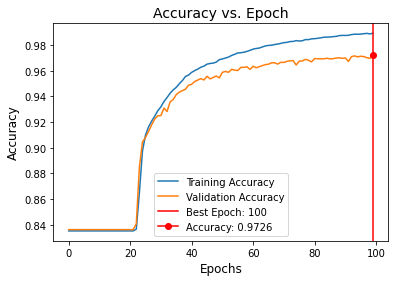

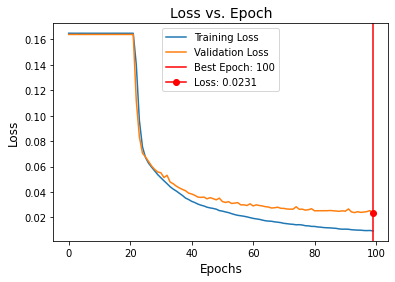

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 100
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True)
torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model.pt')
torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_acc.pt')
torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_loss.pt')

##### Pre-trained Weights (KnK)

Epoch: 1 | Train Loss: 0.12400553 | Train acc: 0.837498
              Val Loss: 0.10501921 |   Val acc: 0.856188
Epoch: 2 | Train Loss: 0.08163295 | Train acc: 0.889352
              Val Loss: 0.06533654 |   Val acc: 0.914067
Epoch: 3 | Train Loss: 0.04819388 | Train acc: 0.938586
              Val Loss: 0.04950349 |   Val acc: 0.931753
Epoch: 4 | Train Loss: 0.03199605 | Train acc: 0.961345
              Val Loss: 0.03594068 |   Val acc: 0.954509
Epoch: 5 | Train Loss: 0.02268996 | Train acc: 0.974107
              Val Loss: 0.03066711 |   Val acc: 0.961230
Epoch: 6 | Train Loss: 0.01671026 | Train acc: 0.982123
              Val Loss: 0.02605261 |   Val acc: 0.967421
Epoch: 7 | Train Loss: 0.01249650 | Train acc: 0.987285
              Val Loss: 0.02389937 |   Val acc: 0.970484
Epoch: 8 | Train Loss: 0.00943015 | Train acc: 0.991110
              Val Loss: 0.02134677 |   Val acc: 0.973710
Epoch: 9 | Train Loss: 0.00729948 | Train acc: 0.993612
              Val Loss: 0.02127674 |   V

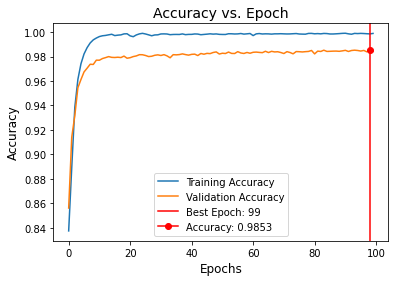

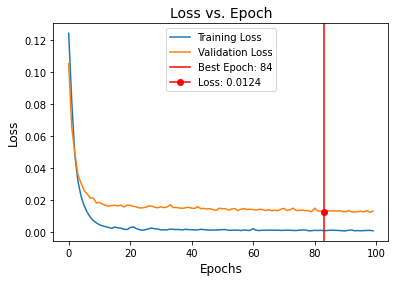

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 100
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)
model_pth = '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/52by5/model.pt'
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=True, model_pth=model_pth)
torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_pt.pt')
torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_acc_pt.pt')
torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_loss_pt.pt')

### Confusion Matrix

In [12]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_pt.pt')

classes = ['Draw', 'Pickup']

#### Train Set

Accuracy: 99.87
Normalized confusion matrix
[[9.99532267e-01 4.67733143e-04]
 [5.57696899e-03 9.94423031e-01]]


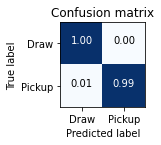

Confusion matrix, without normalization
[[297039    139]
 [   327  58307]]


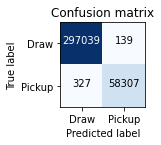

In [14]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

#### Validation Set

Accuracy: 98.43
Normalized confusion matrix
[[0.99317722 0.00682278]
 [0.06129639 0.93870361]]


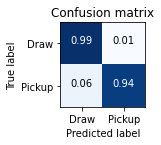

Confusion matrix, without normalization
[[126644    870]
 [  1531  23446]]


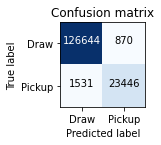

In [15]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader)

#### Test Set (8k)

Accuracy: 99.61
Normalized confusion matrix
[[0.99832829 0.00167171]
 [0.0151441  0.9848559 ]]


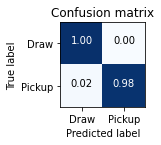

Confusion matrix, without normalization
[[424603    711]
 [  1269  82526]]


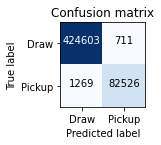

In [16]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_8k_test.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_8k_test.npy')

''' Actions '''
# draw/pickup action only
labels = labels[:,2:4]

data_loader = load_data(states, labels)

model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, data_loader)

#### Test Set (2k)

In [17]:
states_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_2k.npy')
labels_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_2k.npy')

''' Actions '''
# draw/pickup action only
labels_test = labels_test[:,2:4]
test_loader = load_data(states_test, labels_test)

Accuracy: 98.04
Normalized confusion matrix
[[0.99183045 0.00816955]
 [0.07839167 0.92160833]]


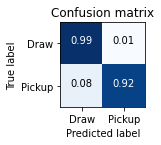

Confusion matrix, without normalization
[[106230    875]
 [  1626  19116]]


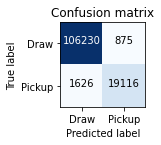

In [18]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_pt.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

Accuracy: 98.11
Normalized confusion matrix
[[0.99042995 0.00957005]
 [0.06686915 0.93313085]]


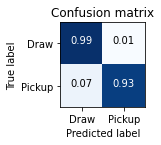

Confusion matrix, without normalization
[[106080   1025]
 [  1387  19355]]


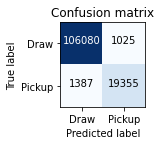

In [19]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_acc_pt.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

Accuracy: 98.08
Normalized confusion matrix
[[0.99040194 0.00959806]
 [0.06855655 0.93144345]]


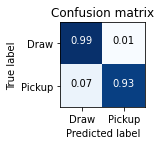

Confusion matrix, without normalization
[[106077   1028]
 [  1422  19320]]


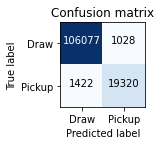

In [20]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_states/model_loss_pt.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

## After Pickup, Before Discard (apbd) Model - All Actions

### Model

#### input_size*2 HU Model

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super(MLP, self).__init__()
        ''' Layer 1 '''
        self.l1 = nn.Linear(input_size, input_size*2)
        # weights uniform distributed [-1/sqrt(n), 1/sqrt(n)]
        bound = 1 / input_size
        nn.init.uniform_(self.l1.weight, -bound, bound)
        # nn.init.xavier_normal_(self.l1.weight)

        ''' Layer 2 '''
        self.l2 = nn.Linear(input_size*2, 110)
        bound = 1 / (input_size*2)
        nn.init.uniform_(self.l2.weight, -bound, bound)
        # nn.init.xavier_normal_(self.l2.weight)
        
        ''' Activation Function '''
        self.sig = nn.Sigmoid()

    def forward(self, features):
        try:
            x = self.l1(features.cuda())
        except:
            x = self.l1(features)
        # x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

### Training

#### Exclude states 3 and 4

In [ ]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_8k.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_8k.npy')

# (1) ignore top card feature
# states[:,(260-52*4):(260-52*3)] = 0

# (2) ignore dead cards feature
# states[:,(260-52*3):(260-52*2)] = 0

# (3) ignore opponent known cards feature
states[:,(260-52*2):(260-52*1)] = 0

# (4) ignore unknown cards feature
states[:,(260-52):(260-52*0)] = 0

data_train, data_val, label_train, label_val = train_test_split(states, labels, test_size=0.3, random_state=421)

In [ ]:
torch.cuda.is_available()

##### Random Weights

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 100
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True)
torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/all_actions/model.pt')
torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/all_actions/model_acc.pt')
torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/all_actions/model_loss.pt')

##### Pre-trained Weights (KnK)

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 100
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)
model_pth = '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/52by5/model.pt'
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=True, model_pth=model_pth)
torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/model_pt.pt')
torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/model_acc_pt.pt')
torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/model_loss_pt.pt')

#### All States

In [ ]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_8k.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_8k.npy')

# (1) ignore top card feature
# states[:,(260-52*4):(260-52*3)] = 0
# (2) ignore dead cards feature
# states[:,(260-52*3):(260-52*2)] = 0
# (3) ignore opponent known cards feature
# states[:,(260-52*2):(260-52*1)] = 0
# (4) ignore unknown cards feature
# states[:,(260-52):(260-52*0)] = 0

data_train, data_val, label_train, label_val = train_test_split(states, labels, test_size=0.3, random_state=421)

##### Random Weights

Epoch: 1 | Train Loss: 0.00369853 | Train acc: 0.832813
              Val Loss: 0.00297912 |   Val acc: 0.836207
Epoch: 2 | Train Loss: 0.00299602 | Train acc: 0.835211
              Val Loss: 0.00297912 |   Val acc: 0.836207
Epoch: 3 | Train Loss: 0.00299608 | Train acc: 0.835211
              Val Loss: 0.00297912 |   Val acc: 0.836207
Epoch: 4 | Train Loss: 0.00299613 | Train acc: 0.835211
              Val Loss: 0.00297912 |   Val acc: 0.836207
Epoch: 5 | Train Loss: 0.00299627 | Train acc: 0.835211
              Val Loss: 0.00297912 |   Val acc: 0.836207
Epoch: 6 | Train Loss: 0.00299610 | Train acc: 0.835211
              Val Loss: 0.00297912 |   Val acc: 0.836207
Epoch: 7 | Train Loss: 0.00299624 | Train acc: 0.835211
              Val Loss: 0.00297912 |   Val acc: 0.836207
Epoch: 8 | Train Loss: 0.00299612 | Train acc: 0.835211
              Val Loss: 0.00297912 |   Val acc: 0.836207
Epoch: 9 | Train Loss: 0.00299633 | Train acc: 0.835211
              Val Loss: 0.00297912 |   V

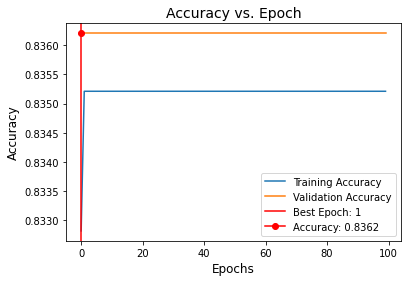

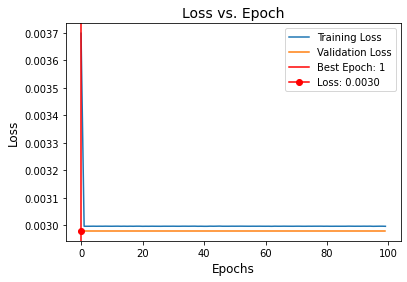

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 100
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True)
torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model.pt')
torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_acc.pt')
torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_loss.pt')

##### Pre-trained Weights (KnK)

Epoch: 1 | Train Loss: 0.00357067 | Train acc: 0.836771
              Val Loss: 0.00206363 |   Val acc: 0.845368
Epoch: 2 | Train Loss: 0.00162393 | Train acc: 0.880369
              Val Loss: 0.00128891 |   Val acc: 0.911096
Epoch: 3 | Train Loss: 0.00090318 | Train acc: 0.937017
              Val Loss: 0.00076549 |   Val acc: 0.949427
Epoch: 4 | Train Loss: 0.00051762 | Train acc: 0.967348
              Val Loss: 0.00046795 |   Val acc: 0.969329
Epoch: 5 | Train Loss: 0.00031998 | Train acc: 0.981729
              Val Loss: 0.00034447 |   Val acc: 0.979225
Epoch: 6 | Train Loss: 0.00020423 | Train acc: 0.989711
              Val Loss: 0.00025000 |   Val acc: 0.985173
Epoch: 7 | Train Loss: 0.00012956 | Train acc: 0.994340
              Val Loss: 0.00019767 |   Val acc: 0.988144
Epoch: 8 | Train Loss: 0.00008717 | Train acc: 0.996804
              Val Loss: 0.00015700 |   Val acc: 0.991586
Epoch: 9 | Train Loss: 0.00005709 | Train acc: 0.998302
              Val Loss: 0.00012661 |   V

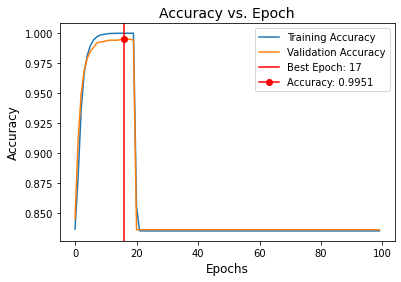

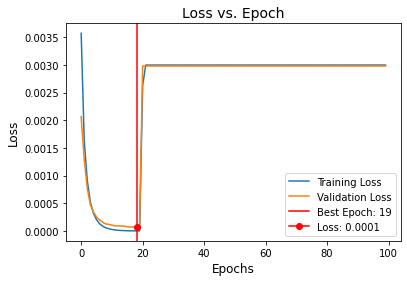

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 100
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)
model_pth = '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/52by5/model.pt'
model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs, verbose=True, pre_train=True, model_pth=model_pth)
torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_pt.pt')
torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_acc_pt.pt')
torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_loss_pt.pt')

### Confusion Matrix

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_pt.pt')

classes = ['SP0','SP1','DC','PC','DH','GIN',
           'AC', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '9C', 'TC', 'JC', 'QC', 'KC',
           'AH', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', 'TH', 'JH', 'QH', 'KH',
           'AS', '2S', '3S', '4S', '5S', '6S', '7S', '8S', '9S', 'TS', 'JS', 'QS', 'KS',
           'AD', '2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', 'TD', 'JD', 'QD', 'KD',
           'AC', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '9C', 'TC', 'JC', 'QC', 'KC',
           'AH', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', 'TH', 'JH', 'QH', 'KH',
           'AS', '2S', '3S', '4S', '5S', '6S', '7S', '8S', '9S', 'TS', 'JS', 'QS', 'KS',
           'AD', '2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', 'TD', 'JD', 'QD', 'KD']

#### Train Set

In [ ]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

Accuracy: 83.52
Normalized confusion matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Confusion matrix, without normalization
[[     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0 297178 ...      0      0      0]
 ...
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]


#### Validation Set

In [ ]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader)

Accuracy: 83.62
Normalized confusion matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Confusion matrix, without normalization
[[     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0 127514 ...      0      0      0]
 ...
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]


#### Test Set (8k)

In [ ]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_8k_test.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_8k_test.npy')
data_loader = load_data(states, labels)

model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, data_loader)

Accuracy: 83.54
Normalized confusion matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Confusion matrix, without normalization
[[     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0 425314 ...      0      0      0]
 ...
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]


#### Test Set (2k)

In [ ]:
states_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_sa_2k.npy')
labels_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/bpbd/bpbd_a_2k.npy')
test_loader = load_data(states_test, labels_test)

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_pt.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

Accuracy: 83.78
Normalized confusion matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Confusion matrix, without normalization
[[     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0 107105 ...      0      0      0]
 ...
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]


In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_acc_pt.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

Accuracy: 99.33
Normalized confusion matrix
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.99688156 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Confusion matrix, without normalization
[[     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0 106771 ...      0      0      0]
 ...
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]


In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/bpbd_pytorch/all_actions/all_states/model_loss_pt.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

Accuracy: 99.35
Normalized confusion matrix
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.99703095 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Confusion matrix, without normalization
[[     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0 106787 ...      0      0      0]
 ...
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]


## Testing

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
import Card
%cd /content/drive/My Drive/Colab Notebooks/Thesis

def one_hot(cards):
    ret = np.zeros(52)
    for card in cards:
        ret[card.getId()] = 1
    return ret

def un_one_hot(arr):
    rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
    # suitNames = ["C", "H", "S", "D"]
    suitNames = ['S', 'H', 'D', 'C']
    ret = []
    for i in range(len(arr)):
        if arr[i] != 0:
            ret.append(rankNames[i%13] + suitNames[i//13])
    return ret

/content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
/content/drive/My Drive/Colab Notebooks/Thesis


### Models

#### input_size*2 HU Model

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, input_size*2)
        self.l2 = nn.Linear(input_size*2, 52)
        self.sig = nn.Sigmoid()

    def forward(self, features):
        try:
            x = self.l1(features.cuda())
        except:
            x = self.l1(features)
        # x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/model_pt.pt')

In [ ]:
model

MLP(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=52, bias=True)
  (sig): Sigmoid()
)

In [ ]:
w = model.l1.weight[0].tolist()
s = ''
for i in range(len(w)):
    if i == 0:
        print('current Hand')
        s = 0
    if i == 52:
        print('\nTop Card')
        s = 1
    if i == 52*2:
        print('\nDead Cards')
        s = 2
    if i == 52*3:
        print('\nOpponent Cards')
        s = 3
    if i == 52*4:
        print('\nUnknown Cards')
        s = 4
    print(Card.Card(i%52%13,i%52//13), w[i])

current Hand
AS -1.5348459482192993
2S -1.321172833442688
3S 1.7454888820648193
4S -6.8473944664001465
5S 1.5805683135986328
6S -0.33266669511795044
7S 1.4189062118530273
8S 1.254576325416565
9S -3.6334290504455566
TS -0.12031250447034836
JS 2.0089635848999023
QS -3.6204817295074463
KS 1.1517945528030396
AH 1.510424256324768
2H 2.472630739212036
3H 0.7023442387580872
4H -4.4089274406433105
5H 0.18349945545196533
6H 0.823142945766449
7H -1.213663101196289
8H 0.14143013954162598
9H -1.6090757846832275
TH 2.884779453277588
JH 2.373929023742676
QH -3.484567403793335
KH 0.91175377368927
AD 0.4615483582019806
2D -1.560917854309082
3D 3.435925245285034
4D -5.006348133087158
5D 4.707463264465332
6D 3.1570096015930176
7D -2.5781702995300293
8D 1.091333270072937
9D -0.8137789368629456
TD 1.090765118598938
JD -7.074990272521973
QD -0.37218713760375977
KD 3.159351110458374
AC 1.5937424898147583
2C -2.0086560249328613
3C -2.366696834564209
4C 13.601096153259277
5C -6.9039483070373535
6C -2.68944978

### Function Definition

In [ ]:
allCardsNames = 'AC 2C 3C 4C 5C 6C 7C 8C 9C TC JC QC KC AH 2H 3H 4H 5H 6H 7H 8H 9H TH JH QH KH AS 2S 3S 4S 5S 6S 7S 8S 9S TS JS QS KS AD 2D 3D 4D 5D 6D 7D 8D 9D TD JD QD KD'
allCardsNamesArr = allCardsNames.split(' ')
allCards = []
for cardName in allCardsNamesArr:
    allCards.append(Deck.strCardMap[cardName])

def meldedHand(cards):
    unmeldedCards = cards.copy()
    bestMelds = GinRummyUtil.cardsToBestMeldSets(unmeldedCards)
    if len(bestMelds) == 0:
        melds = unmeldedCards
        deadwood = GinRummyUtil.getDeadwoodPoints3(unmeldedCards)
    else:
        melds = bestMelds[0]
        for meld in melds:
            # print(meld)
            for card in meld:
                # print(card)
                # print(unmeldedCards)
                unmeldedCards.remove(card)
        melds.extend(unmeldedCards)
        deadwood = GinRummyUtil.getDeadwoodPoints3(unmeldedCards)
    return melds, deadwood

def testHand(cards):
    meldSet, deadwood = meldedHand(cards)
    print("%s with %d deadwood." % (meldSet, deadwood))
    label = deadwood <= 10
    input = one_hot(cards)
    input = np.expand_dims(input,axis=0)
    prob = float(model(torch.from_numpy(input).type(torch.FloatTensor)))
    print('Predicted Output:', prob)
    guess = prob > 0.5
    if guess and label: # TN
        print('Correct! Model guessed knocked')
        return 'TN'
        # pass
    elif not guess and not label: # TP
        print('Correct! Model guessed NOT knocked')
        return 'TP'
        # pass
    elif guess and not label:   #FP
        # print("%s with %d deadwood." % (meldSet, deadwood))
        # print('Predicted Output:', prob)
        print('Incorrect! Model guessed knocked')
        print('\n\n')
        return 'FP'
    elif not guess and label: # FN
        # print("%s with %d deadwood." % (meldSet, deadwood))
        # print('Predicted Output:', prob)
        print('Incorrect! Model guessed NOT knocked')
        print('\n\n')
        return 'FN'

In [ ]:
cardNames = '[AS, AH, AC, 2C, 3C, 4C, 4H, 4D, 4S, 5C]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
testHand(hand)


# DQN

In [ ]:
!pip install rlcard
!pip install rlcard[torch]
!pip install rlcard[tensorflow]

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis


In [ ]:
import torch
import tensorflow as tf

print(torch.__version__)
print(tf.__version__)

1.7.0+cu101
1.15.4


## DQN Customized

In [ ]:
''' DQN agent
The code is derived from https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/dqn.py
Copyright (c) 2019 Matthew Judell
Copyright (c) 2019 DATA Lab at Texas A&M University
Copyright (c) 2016 Denny Britz
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

import numpy as np
import torch
import torch.nn as nn
from collections import namedtuple
from copy import deepcopy

from rlcard.agents.dqn_agent import Memory
from rlcard.utils.utils import remove_illegal

Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])


class DQNAgent(object):
    '''
    Approximate clone of rlcard.agents.dqn_agent.DQNAgent
    that depends on PyTorch instead of Tensorflow
    '''
    def __init__(self,
                 scope,
                 replay_memory_size=20000,
                 replay_memory_init_size=100,
                 update_target_estimator_every=1000,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=32,
                 action_num=2,
                 state_shape=None,
                 train_every=1,
                 mlp_layers=None,
                 learning_rate=0.00005,
                 device=None):

        '''
        Q-Learning algorithm for off-policy TD control using Function Approximation.
        Finds the optimal greedy policy while following an epsilon-greedy policy.
        Args:
            scope (str): The name of the DQN agent
            replay_memory_size (int): Size of the replay memory
            replay_memory_init_size (int): Number of random experiences to sampel when initializing
              the reply memory.
            update_target_estimator_every (int): Copy parameters from the Q estimator to the
              target estimator every N steps
            discount_factor (float): Gamma discount factor
            epsilon_start (int): Chance to sample a random action when taking an action.
              Epsilon is decayed over time and this is the start value
            epsilon_end (int): The final minimum value of epsilon after decaying is done
            epsilon_decay_steps (int): Number of steps to decay epsilon over
            batch_size (int): Size of batches to sample from the replay memory
            evaluate_every (int): Evaluate every N steps
            action_num (int): The number of the actions
            state_space (list): The space of the state vector
            train_every (int): Train the network every X steps.
            mlp_layers (list): The layer number and the dimension of each layer in MLP
            learning_rate (float): The learning rate of the DQN agent.
            device (torch.device): whether to use the cpu or gpu
        '''
        self.use_raw = False
        self.scope = scope
        self.replay_memory_init_size = replay_memory_init_size
        self.update_target_estimator_every = update_target_estimator_every
        self.discount_factor = discount_factor
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.action_num = action_num
        self.train_every = train_every

        # Torch device
        if device is None:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        # Total timesteps
        self.total_t = 0

        # Total training step
        self.train_t = 0

        # The epsilon decay scheduler
        self.epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

        # Create estimators
        self.q_estimator = Estimator(action_num=action_num, learning_rate=learning_rate, state_shape=state_shape, \
            mlp_layers=mlp_layers, device=self.device)
        self.target_estimator = Estimator(action_num=action_num, learning_rate=learning_rate, state_shape=state_shape, \
            mlp_layers=mlp_layers, device=self.device)

        # Create replay memory
        self.memory = Memory(replay_memory_size, batch_size)

    def feed(self, ts):
        ''' Store data in to replay buffer and train the agent. There are two stages.
            In stage 1, populate the memory without training
            In stage 2, train the agent every several timesteps
        Args:
            ts (list): a list of 5 elements that represent the transition
        '''
        (state, action, reward, next_state, done) = tuple(ts)
        self.feed_memory(state['obs'], action, reward, next_state['obs'], done)
        self.total_t += 1
        tmp = self.total_t - self.replay_memory_init_size
        if tmp>=0 and tmp%self.train_every == 0:
            self.train()

    def step(self, state):
        ''' Predict the action for genrating training data but
            have the predictions disconnected from the computation graph
        Args:
            state (numpy.array): current state
        Returns:
            action (int): an action id
        '''
        A = self.predict(state['obs'])
        A = remove_illegal(A, state['legal_actions'])
        action = np.random.choice(np.arange(len(A)), p=A)
        return action

    def eval_step(self, state):
        ''' Predict the action for evaluation purpose.
        Args:
            state (numpy.array): current state
        Returns:
            action (int): an action id
        '''
        q_values = self.q_estimator.predict_nograd(np.expand_dims(state['obs'], 0))[0]
        probs = remove_illegal(np.exp(q_values), state['legal_actions'])
        best_action = np.argmax(probs)
        return best_action, probs

    def predict(self, state):
        ''' Predict the action probabilities but have them
            disconnected from the computation graph
        Args:
            state (numpy.array): current state
        Returns:
            q_values (numpy.array): a 1-d array where each entry represents a Q value
        '''
        epsilon = self.epsilons[min(self.total_t, self.epsilon_decay_steps-1)]
        A = np.ones(self.action_num, dtype=float) * epsilon / self.action_num
        q_values = self.q_estimator.predict_nograd(np.expand_dims(state, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A

    def train(self):
        ''' Train the network
        Returns:
            loss (float): The loss of the current batch.
        '''
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample()

        # Calculate best next actions using Q-network (Double DQN)
        q_values_next = self.q_estimator.predict_nograd(next_state_batch)
        best_actions = np.argmax(q_values_next, axis=1)

        # Evaluate best next actions using Target-network (Double DQN)
        q_values_next_target = self.target_estimator.predict_nograd(next_state_batch)
        target_batch = reward_batch + np.invert(done_batch).astype(np.float32) * \
            self.discount_factor * q_values_next_target[np.arange(self.batch_size), best_actions]

        # Perform gradient descent update
        state_batch = np.array(state_batch)

        loss = self.q_estimator.update(state_batch, action_batch, target_batch)
        print('\rINFO - Agent {}, step {}, rl-loss: {}'.format(self.scope, self.total_t, loss), end='')

        # Update the target estimator
        if self.train_t % self.update_target_estimator_every == 0:
            self.target_estimator = deepcopy(self.q_estimator)
            print("\nINFO - Copied model parameters to target network.")

        self.train_t += 1

    def feed_memory(self, state, action, reward, next_state, done):
        ''' Feed transition to memory
        Args:
            state (numpy.array): the current state
            action (int): the performed action ID
            reward (float): the reward received
            next_state (numpy.array): the next state after performing the action
            done (boolean): whether the episode is finished
        '''
        self.memory.save(state, action, reward, next_state, done)

    def get_state_dict(self):
        ''' Get the state dict to save models
        Returns:
            (dict): A dict of model states
        '''
        q_key = self.scope + '_q_estimator'
        q_value = self.q_estimator.qnet.state_dict()
        target_key = self.scope + '_target_estimator'
        target_value = self.target_estimator.qnet.state_dict()
        return {q_key: q_value, target_key: target_value}

    def load(self, checkpoint):
        ''' Load model
        Args:
            checkpoint (dict): the loaded state
        '''
        q_key = self.scope + '_q_estimator'
        self.q_estimator.qnet.load_state_dict(checkpoint[q_key])
        target_key = self.scope + '_target_estimator'
        self.target_estimator.qnet.load_state_dict(checkpoint[target_key])

class Estimator(object):
    '''
    Approximate clone of rlcard.agents.dqn_agent.Estimator that
    uses PyTorch instead of Tensorflow.  All methods input/output np.ndarray.
    Q-Value Estimator neural network.
    This network is used for both the Q-Network and the Target Network.
    '''

    def __init__(self, action_num=2, learning_rate=0.001, state_shape=None, mlp_layers=None, device=None):
        ''' Initilalize an Estimator object.
        Args:
            action_num (int): the number output actions
            state_shape (list): the shape of the state space
            mlp_layers (list): size of outputs of mlp layers
            device (torch.device): whether to use cpu or gpu
        '''
        self.action_num = action_num
        self.learning_rate=learning_rate
        self.state_shape = state_shape
        self.mlp_layers = mlp_layers
        self.device = device

        # set up Q model and place it in eval mode
        qnet = EstimatorNetwork(action_num, state_shape, mlp_layers)
        qnet = qnet.to(self.device)
        self.qnet = qnet
        self.qnet.eval()

        # initialize the weights using Xavier init
        for p in self.qnet.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        # set up loss function
        self.mse_loss = nn.MSELoss(reduction='mean')

        # set up optimizer
        self.optimizer =  torch.optim.Adam(self.qnet.parameters(), lr=self.learning_rate)

    def predict_nograd(self, s):
        ''' Predicts action values, but prediction is not included
            in the computation graph.  It is used to predict optimal next
            actions in the Double-DQN algorithm.
        Args:
          s (np.ndarray): (batch, state_len)
        Returns:
          np.ndarray of shape (batch_size, NUM_VALID_ACTIONS) containing the estimated
          action values.
        '''
        with torch.no_grad():
            s = torch.from_numpy(s).float().to(self.device)
            q_as = self.qnet(s).cpu().numpy()
        return q_as

    def update(self, s, a, y):
        ''' Updates the estimator towards the given targets.
            In this case y is the target-network estimated
            value of the Q-network optimal actions, which
            is labeled y in Algorithm 1 of Minh et al. (2015)
        Args:
          s (np.ndarray): (batch, state_shape) state representation
          a (np.ndarray): (batch,) integer sampled actions
          y (np.ndarray): (batch,) value of optimal actions according to Q-target
        Returns:
          The calculated loss on the batch.
        '''
        self.optimizer.zero_grad()

        self.qnet.train()

        s = torch.from_numpy(s).float().to(self.device)
        a = torch.from_numpy(a).long().to(self.device)
        y = torch.from_numpy(y).float().to(self.device)

        # (batch, state_shape) -> (batch, action_num)
        q_as = self.qnet(s)

        # (batch, action_num) -> (batch, )
        Q = torch.gather(q_as, dim=-1, index=a.unsqueeze(-1)).squeeze(-1)

        # update model
        batch_loss = self.mse_loss(Q, y)
        batch_loss.backward()
        self.optimizer.step()
        batch_loss = batch_loss.item()

        self.qnet.eval()

        return batch_loss


class EstimatorNetwork(nn.Module):
    ''' The function approximation network for Estimator
        It is just a series of tanh layers. All in/out are torch.tensor
    '''

    def __init__(self, action_num=2, state_shape=None, mlp_layers=None):
        ''' Initialize the Q network
        Args:
            action_num (int): number of legal actions
            state_shape (list): shape of state tensor
            mlp_layers (list): output size of each fc layer
        '''
        super(EstimatorNetwork, self).__init__()

        self.action_num = action_num
        self.state_shape = state_shape
        self.mlp_layers = mlp_layers

        # build the Q network
        layer_dims = [np.prod(self.state_shape)] + self.mlp_layers
        fc = [nn.Flatten()]
        fc.append(nn.BatchNorm1d(layer_dims[0]))
        for i in range(len(layer_dims)-1):
            fc.append(nn.Linear(layer_dims[i], layer_dims[i+1], bias=True))
            fc.append(nn.Sigmoid())
        fc.append(nn.Linear(layer_dims[-1], self.action_num, bias=True))
        self.fc_layers = nn.Sequential(*fc)
        # self.l1 = nn.Linear(input_size, input_size*2)
        # self.l2 = nn.Linear(input_size*2, 1)
        # self.sig = nn.Sigmoid()

    def forward(self, s):
        ''' Predict action values
        Args:
            s  (Tensor): (batch, state_shape)
        '''
        return self.fc_layers(s)
        # x = self.l1(nn.Flatten(s))
        # x = self.sig(x)
        # x = self.l2(x)
        # return self.sig(x)

### Experiments

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/model_pt.pt')

In [ ]:
model.l1.weight.cpu()

tensor([[-1.5348e+00, -1.3212e+00,  1.7455e+00,  ...,  4.4827e-02,
          4.6710e-02, -3.4218e-02],
        [ 2.9515e+00, -8.4011e-01,  8.9235e-01,  ..., -1.0771e-02,
          2.0655e-02, -5.8781e-03],
        [-3.3204e-01, -3.1470e-01, -3.7012e-01,  ...,  1.3609e-02,
          8.4998e-03,  3.6893e-02],
        ...,
        [-1.6948e+00, -1.7720e+00,  9.3538e+00,  ..., -1.2536e-02,
         -4.9882e-02, -5.5409e-02],
        [-2.5379e+00, -1.6696e+00, -2.0588e+00,  ..., -2.2529e-02,
         -2.2292e-02, -5.4467e-02],
        [-2.1017e+00, -6.5800e-01, -1.3593e+00,  ...,  2.1683e-02,
         -1.4672e-02, -2.4222e-02]], grad_fn=<CopyBackwards>)

In [ ]:
agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520, 1],
                 device=torch.device('cpu'))

In [ ]:
agent.q_estimator.qnet.fc_layers[2].weight = model.l1.weight
agent.q_estimator.qnet.fc_layers[2].bias = model.l1.bias
agent.q_estimator.qnet.fc_layers[4].weight = model.l2.weight
agent.q_estimator.qnet.fc_layers[4].bias = model.l2.bias

In [ ]:
agent.q_estimator.qnet.fc_layers[2].weight


Parameter containing:
tensor([[-1.2913e-02,  1.7555e-02, -6.8227e-02,  ..., -7.2687e-02,
          7.2696e-05, -8.6314e-02],
        [-7.4512e-02,  4.7105e-02,  6.1485e-02,  ...,  5.1628e-02,
          2.0472e-02, -8.7519e-02],
        [-2.8611e-02, -2.6829e-02, -4.9708e-02,  ...,  8.7605e-02,
          1.5988e-02,  4.0572e-03],
        ...,
        [ 4.5356e-02,  2.4573e-02, -5.1773e-02,  ...,  3.2959e-02,
          2.4060e-03, -4.8993e-03],
        [-4.9848e-02, -2.1334e-03, -3.2256e-02,  ...,  1.4862e-02,
          7.3959e-02, -6.6445e-02],
        [-1.6038e-02, -1.8058e-02, -4.7224e-02,  ...,  1.3438e-02,
          6.3478e-02,  9.8711e-03]], requires_grad=True)

In [ ]:
torch.nn.Parameter(model.l1.weight.cpu())

Parameter containing:
tensor([[-1.5348e+00, -1.3212e+00,  1.7455e+00,  ...,  4.4827e-02,
          4.6710e-02, -3.4218e-02],
        [ 2.9515e+00, -8.4011e-01,  8.9235e-01,  ..., -1.0771e-02,
          2.0655e-02, -5.8781e-03],
        [-3.3204e-01, -3.1470e-01, -3.7012e-01,  ...,  1.3609e-02,
          8.4998e-03,  3.6893e-02],
        ...,
        [-1.6948e+00, -1.7720e+00,  9.3538e+00,  ..., -1.2536e-02,
         -4.9882e-02, -5.5409e-02],
        [-2.5379e+00, -1.6696e+00, -2.0588e+00,  ..., -2.2529e-02,
         -2.2292e-02, -5.4467e-02],
        [-2.1017e+00, -6.5800e-01, -1.3593e+00,  ...,  2.1683e-02,
         -1.4672e-02, -2.4222e-02]], requires_grad=True)

## Run

### Pretrained

In [ ]:
import copy
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, 305)
        self.l2 = nn.Linear(305, 1)
        self.sig = nn.Sigmoid()

    def forward(self, features):
        # try:
        #     x = self.l1(features.cuda())
        # except:
        #     x = self.l1(features)
        x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False

----------------------------------------
  timestep     |  136
  reward       |  -0.5181
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.1182563379406929
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.04826102405786514
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.030353372916579247
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.011231296695768833
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 5000, rl-loss: 0.011672429740428925
INFO - Copied model parameters to

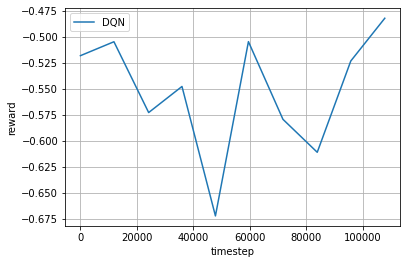

In [ ]:
import torch
import tensorflow
import os

import rlcard
# from rlcard.agents import DQNAgentPytorch as DQNAgent
from rlcard.agents import RandomAgent
from rlcard.utils import set_global_seed, tournament
from rlcard.utils import Logger

# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 1000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

# The paths for saving the logs and learning curves
log_dir = './experiments/gin_rummy_dqn_result/apbd'

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520, 52],
                 device=torch.device('cpu'))

model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/apbd_pytorch/model_pt.pt')
# load pretrained weights
agent.q_estimator.qnet.fc_layers[2].weight = torch.nn.Parameter(model.l1.weight.cpu())
agent.q_estimator.qnet.fc_layers[2].bias = torch.nn.Parameter(model.l1.bias.cpu())
agent.q_estimator.qnet.fc_layers[4].weight = torch.nn.Parameter(model.l2.weight.cpu())
agent.q_estimator.qnet.fc_layers[4].bias = torch.nn.Parameter(model.l2.bias.cpu())

# agent.target_estimator.qnet.fc_layers[2].weight = torch.nn.Parameter(model.l1.weight.cpu())
# agent.target_estimator.qnet.fc_layers[2].bias = torch.nn.Parameter(model.l1.bias.cpu())
# agent.target_estimator.qnet.fc_layers[4].weight = torch.nn.Parameter(model.l2.weight.cpu())
# agent.target_estimator.qnet.fc_layers[4].bias = torch.nn.Parameter(model.l2.bias.cpu())

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
save_dir = 'models/gin_rummy_dqn_pytorch/apbd'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
print(state_dict. keys())
torch.save(state_dict, os.path.join(save_dir, 'model.pth'))